# Nexus Scatter
9.14.2022, a. stein

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_2311824/1988245056.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load in Data

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [3]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc').load()

In [4]:
intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]

In [5]:
spi = xr.open_dataset(f'{dm_path}/spi/WA/spi_usdmcat_WA.nc').load()

In [6]:
spei = xr.open_dataset(f'{dm_path}/spei/WA/spei_usdmcat_WA.nc').load()

In [7]:
eddi = xr.open_dataset(f'{dm_path}/eddi/WA/eddi_usdmcat_WA.nc').load()

In [8]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi_usdmcat_WA.nc').load()

In [9]:
grace = xr.open_dataset(f'{dm_path}/grace/WA/grace_usdmcat_WA.nc').load()
grace_vars = ['gws', 'rtzsm', 'sfsm']

## Pairing

### Dates

In [10]:
def pair_dates(dates_a:pd.DatetimeIndex, dates_b:pd.DatetimeIndex, dates_a_name:str, dates_b_name:str, method='last-b', realign=False):
    """Pairs dates between two metrics for comparison.
    
    Note that this was developed for SPI and USDM and should be double checked.

    WARNING: The current catch for too-many dates provided is experimental.

    Parameters
    ----------
    dates_a: DateTimeIndex
    dates_b: DateTimeIndex
    dates_a_name: str
        Name of dates_a.
    dates_b_name: str
        Name of dates_b.
    method: str
        How to pair dates between dates_a and dates_b. The following are
        currently supported:
        - last-a: match dates_b to the last dates_a available. Use if there
            is reason to believe that measure A informs measure B
        - last-b: match dates_a to the last dates_b available. Use if there
            is reason to believe that measure B informs measure A
        - nearest: dates are paired by their nearest neighbors, dropping any
            dates that are not chosen in the process. Use if there is no
            reason to believe A nor B inform each other and do not want
            an aggregate process

        To come:
        - cluster-a: match all dates_b to their nearest dates_a, which
            can result in multiple dates being assigned to a date in dates_a
            and an aggregation scheme should be used in the data. Use if
            believe B informs A and wanting to allow for multi-pairing.
        - cluster-b: match all dates_a to their nearest dates_b, which
            can result in multiple dates being assigned to a date in dates_b
            and an aggregation scheme should be used in the data. Use if
            believe A informs B and wanting to allow for multi-pairing.
        - cluster-nearest: each date is assigned to the nearest other date,
            being the only method to guarantee no dates are dropped in pairing.
            Use if there is no strong belief that one measure dominantly
            influences the other and wanting to allow for multi-pairing.
    realign: boolean, (optional)
        Whether to automatically clip dates to ensure proper pairing,
        defaults as False.

    Returns
    -------
    pd.DataFrame
        DataFrame where each row pairs an dates_b to a dates_a.
    """

    # check if times are too far out of alignment
    if dates_a[-1] - pd.Timedelta(days=7) > dates_b[-1]:
        if realign:
            dates_a = dates_a[dates_a <= dates_b[-1] + pd.Timedelta(days=7)]
        else:
            raise Exception('dates_a extends more than a week beyond dates_b, resulting in an inability to pair. Please adjust dates_a accordingly or set realign=True to (experimentally) automatically correct.')
    if dates_b[-1] - pd.Timedelta(days=7) > dates_a[-1]:
        if realign:
            dates_b = dates_b[dates_b <= dates_a[-1] + pd.Timedelta(days=7)]
        else:
            raise Exception('dates_b extends more than a week beyond dates_a, resulting in an inability to pair. Please adjust dates_b accordingly or set realign=True to (experimentally) automatically correct.')
    if dates_b[0] + pd.Timedelta(days=7) < dates_a[-1]:
        if realign:
            dates_b = dates_b[dates_b >= dates_a[0] - pd.Timedelta(days=7)]
        else:
            raise Exception('dates_b extends more than a week prior to dates_a, resulting in an inability to pair. Please adjust dates_b accordingly or set realign=True to (experimentally) automatically correct')
    if dates_a[0] + pd.Timedelta(days=7) < dates_b[-1]:
        if realign:
            dates_a = dates_a[dates_a >= dates_b[0] - pd.Timedelta(days=7)]
        else:
            raise Exception('dates_a extends more than a week prior to dates_b, resulting in an inability to pair. Please adjust dates_a accordingly or set realign=True to (experimentally) automatically correct')

    # now we need to iterate through and find which other dates are the closest
    # and pair them
    if method == 'last-b':
        pair_dates = pd.DataFrame(pd.Series(dates_b, name=dates_b_name))
        # add the column for dates_a dates
        pair_dates[dates_a_name] = np.nan * np.zeros(len(pair_dates[dates_b_name]))

        i = 0
        for date in dates_a:
            if date >= dates_b[i]:
                while i < len(dates_b)-1 and dates_b[i+1] <= date:
                    i += 1
                if not isinstance(pair_dates[dates_a_name].iloc[i], pd.Timestamp):
                    pair_dates[dates_a_name].iloc[i] = date
    elif method == 'last-a':
        pair_dates = pd.DataFrame(pd.Series(dates_a, name=dates_a_name))
        # add the column for dates_b dates
        pair_dates[dates_b_name] = np.nan * np.zeros(len(pair_dates[dates_a_name]))

        i = 0
        for date in dates_b:
            if date >= dates_a[i]:
                while i < len(dates_a)-1 and dates_a[i+1] <= date:
                    i += 1
                if not isinstance(pair_dates[dates_b_name].iloc[i], pd.Timestamp):
                    pair_dates[dates_b_name].iloc[i] = date
    elif method == 'nearest':
        i = 0
        j = 0
        pairs = []

        # go through and match each date in A with the nearest date in B
        while i < len(dates_a) and j < len(dates_b):
            current_difference = np.abs(dates_a[i] - dates_b[j])

            # if we've gotten to the end of the list, match with
            # it and reset our search
            if j+1 == len(dates_b):
                pairs.append((dates_a[i], dates_b[j]))
                i += 1
                j = 0
            # if there is an exact match or the found date is closer
            # than the following, consider it a match
            elif current_difference == pd.Timedelta('0 day') or current_difference < np.abs(dates_a[i] - dates_b[j+1]):
                pairs.append((dates_a[i], dates_b[j]))
                i += 1
            # keep looking
            else:
                j += 1

        # now need to trim duplicate pairings

        paired_b = np.array(pairs)[:, 1]
        remove_pairs = []

        for date in dates_b:
            found_pairs = np.where(date == paired_b)[0]
            # check if found more than one pairing
            if len(found_pairs > 1):
                # gather differences
                deltas = []
                for duplicate in found_pairs:
                    pairing = pairs[duplicate]
                    deltas.append(np.abs(pairing[0] - pairing[1]))
                # find closest
                minimum_index = np.argmin(np.array(deltas))
                minimum_pairing = pairs[found_pairs[minimum_index]]
            # collect which pairs to remove (removing now would mess
            # with the ordering of things)
            for duplicate in found_pairs:
                pairing = pairs[duplicate]
                if pairing != minimum_pairing:
                    remove_pairs.append(pairing)
        # finally remove unfavorable duplicates
        for pair in remove_pairs:
            pairs.remove(pair)
            
        pair_dates = pd.DataFrame(data=np.array(pairs), columns=[dates_a_name, dates_b_name])
            
    #elif method == 'cluster-a':
    #elif method == 'cluster-b':
    #elif method == 'cluster-nearest':
    else:
        raise Exception(f'{method} is not a supported method. Please visit the documentation for supported methods.')

    # now drop the dates that did not get chosen
    pair_dates = pair_dates.dropna('index')
    # reset the index
    pair_dates = pair_dates.reset_index()
    # and make sure to drop pandas trying to preserve the old index
    pair_dates = pair_dates.drop(columns='index')

    return pair_dates

In [11]:
dates_a = pd.to_datetime([f'2000-01-{i}' for i in [2, 9, 16, 23]])
dates_b = pd.to_datetime([f'2000-01-{i}' for i in [1, 6, 11, 16, 21, 26]])

In [12]:
pair_dates(dates_a, dates_b, "A", "B", method='last-b', realign=True)

,B,A
0,2000-01-01,2000-01-02 00:00:00
1,2000-01-06,2000-01-09 00:00:00
2,2000-01-16,2000-01-16 00:00:00
3,2000-01-21,2000-01-23 00:00:00


In [13]:
pair_dates(dates_a, dates_b, "A", "B", method='last-a', realign=True)

,A,B
0,2000-01-02,2000-01-06 00:00:00
1,2000-01-09,2000-01-11 00:00:00
2,2000-01-16,2000-01-16 00:00:00
3,2000-01-23,2000-01-26 00:00:00


In [14]:
i = 0
j = 0

pairs = []

nearest_threshold = pd.Timedelta('10 day')
difference = nearest_threshold
while i < len(dates_a) and j < len(dates_b):
    print(i, j, np.abs(dates_a[i] - dates_b[j]))

    current_difference = np.abs(dates_a[i] - dates_b[j])

    if current_difference < difference:
        difference = current_difference
        j += 1
    elif current_difference >= nearest_threshold:
        j += 1
    else:
        pairs.append((dates_a[i], dates_b[j-1]))
        difference = nearest_threshold
        i += 1
        j = 0

0 0 1 days 00:00:00
0 1 4 days 00:00:00
1 0 8 days 00:00:00
1 1 3 days 00:00:00
1 2 2 days 00:00:00
1 3 7 days 00:00:00
2 0 15 days 00:00:00
2 1 10 days 00:00:00
2 2 5 days 00:00:00
2 3 0 days 00:00:00
2 4 5 days 00:00:00
3 0 22 days 00:00:00
3 1 17 days 00:00:00
3 2 12 days 00:00:00
3 3 7 days 00:00:00
3 4 2 days 00:00:00
3 5 3 days 00:00:00


In [15]:
pairs

[(Timestamp('2000-01-02 00:00:00'), Timestamp('2000-01-01 00:00:00')),
 (Timestamp('2000-01-09 00:00:00'), Timestamp('2000-01-11 00:00:00')),
 (Timestamp('2000-01-16 00:00:00'), Timestamp('2000-01-16 00:00:00')),
 (Timestamp('2000-01-23 00:00:00'), Timestamp('2000-01-21 00:00:00'))]

In [16]:
len(dates_a)

4

In [17]:
len(dates_b)

6

In [18]:
i = 0
j = 0

pairs = []

#nearest_threshold = pd.Timedelta('10 day')
#difference = nearest_threshold
while i < len(dates_b) and j < len(dates_a):
    print(i, j, np.abs(dates_b[i] - dates_a[j]))

    current_difference = np.abs(dates_b[i] - dates_a[j])

    if j + 1 == len(dates_a):
        pairs.append((dates_b[i], dates_a[j]))
        i += 1
        j = 0
    elif current_difference == pd.Timedelta('0 day') or current_difference < np.abs(dates_b[i] - dates_a[j+1]):
        pairs.append((dates_b[i], dates_a[j]))
        i += 1
    else:
        j += 1
    

0 0 1 days 00:00:00
1 0 4 days 00:00:00
1 1 3 days 00:00:00
2 1 2 days 00:00:00
3 1 7 days 00:00:00
3 2 0 days 00:00:00
4 2 5 days 00:00:00
4 3 2 days 00:00:00
5 0 24 days 00:00:00
5 1 17 days 00:00:00
5 2 10 days 00:00:00
5 3 3 days 00:00:00


In [19]:
pairs

[(Timestamp('2000-01-01 00:00:00'), Timestamp('2000-01-02 00:00:00')),
 (Timestamp('2000-01-06 00:00:00'), Timestamp('2000-01-09 00:00:00')),
 (Timestamp('2000-01-11 00:00:00'), Timestamp('2000-01-09 00:00:00')),
 (Timestamp('2000-01-16 00:00:00'), Timestamp('2000-01-16 00:00:00')),
 (Timestamp('2000-01-21 00:00:00'), Timestamp('2000-01-23 00:00:00')),
 (Timestamp('2000-01-26 00:00:00'), Timestamp('2000-01-23 00:00:00'))]

In [20]:
# trimming

paired_a = np.array(pairs)[:, 1]

remove_pairs = []
for date in dates_a:
    found_pairs = np.where(date == paired_a)[0]
    if len(found_pairs) > 1:

        print(found_pairs)
        deltas = []
        for duplicate in found_pairs:
            pairing = pairs[duplicate]
            print(pairing)
            deltas.append(np.abs(pairing[0] - pairing[1]))
            
        deltas = np.array(deltas)
        minimum_index = np.argmin(deltas)
        minimum_pairing = pairs[found_pairs[minimum_index]]
        
        for duplicate in found_pairs:
            pairing = pairs[duplicate]
            if pairing != minimum_pairing:
                remove_pairs.append(pairing)

for pair in remove_pairs:
    pairs.remove(pair)

[1 2]
(Timestamp('2000-01-06 00:00:00'), Timestamp('2000-01-09 00:00:00'))
(Timestamp('2000-01-11 00:00:00'), Timestamp('2000-01-09 00:00:00'))
[4 5]
(Timestamp('2000-01-21 00:00:00'), Timestamp('2000-01-23 00:00:00'))
(Timestamp('2000-01-26 00:00:00'), Timestamp('2000-01-23 00:00:00'))


In [21]:
pairs

[(Timestamp('2000-01-01 00:00:00'), Timestamp('2000-01-02 00:00:00')),
 (Timestamp('2000-01-11 00:00:00'), Timestamp('2000-01-09 00:00:00')),
 (Timestamp('2000-01-16 00:00:00'), Timestamp('2000-01-16 00:00:00')),
 (Timestamp('2000-01-21 00:00:00'), Timestamp('2000-01-23 00:00:00'))]

In [22]:
pd.DataFrame(data=np.array(pairs), columns=['B', 'A'])

,B,A
0,2000-01-01,2000-01-02
1,2000-01-11,2000-01-09
2,2000-01-16,2000-01-16
3,2000-01-21,2000-01-23


In [23]:
pair_dates(dates_a, dates_b, 'A', 'B', realign=True, method='nearest')

,A,B
0,2000-01-02,2000-01-01
1,2000-01-09,2000-01-11
2,2000-01-16,2000-01-16
3,2000-01-23,2000-01-21


In [24]:
pair_dates(dates_b, dates_a, 'B', 'A', realign=True, method='nearest')

,B,A
0,2000-01-01,2000-01-02
1,2000-01-11,2000-01-09
2,2000-01-16,2000-01-16
3,2000-01-21,2000-01-23


Wonderful. I'll worry about the cluster methods another time because I'd have to contemplate aggregation methods as well.

Let's get all the actual data pairings. 

In [25]:
usdm_dates = pd.to_datetime(usdm.date.values)
spi_dates = pd.to_datetime(spi.day.values)
spei_dates = pd.to_datetime(spei.day.values)
eddi_dates = pd.to_datetime(eddi.day.values)
pdsi_dates = pd.to_datetime(pdsi.day.values)
grace_dates = pd.to_datetime(grace.time.values)

In [26]:
all_dates = [usdm_dates, spi_dates, spei_dates, eddi_dates, pdsi_dates, grace_dates]
dm_vars = ['usdm', 'spi', 'spei', 'eddi', 'pdsi', 'grace']

Okay, so I think for any combination with USDM, I want to assume that the other measure informs USDM ... which would be using "last-b" with A=USDM and B=Other.

Let's go ahead and mak ea hypothetical drought nexus (done on whiteboard) of what the matching schemes then should be.

- **USDM**: is informed by every measure
- **SPI**: informs all measures except GRACE; GRACE informs it
- **SPEI**: informs USDM, PDSI, and EDDI; it is informed by SPI and GRACE
- **EDDI**: informs USDM, it is informed by all others but PDSI (which likely shares patterns but neither of them strongly dominate the other)
- **PDSI**: informs USDM,  it is informed by all others but EDDI (which likely shares patterns but neither of them strongly dominate the other)
- **GRACE**: informs all measures


In [27]:
usdm_pairings = dict()

for date, var in zip(all_dates[1:], dm_vars[1:]):
    usdm_pairings[var] = pair_dates(usdm_dates, date, 'usdm', var, realign=True, method='last-b')

In [28]:
spi_pairings = dict()

for date, var in zip(all_dates, dm_vars):
    if var != 'spi':
        if var == 'grace':
            method = 'last-b'
        else:
            method = 'last-a'
        
        spi_pairings[var] = pair_dates(spi_dates, date, 'spi', var, realign=True, method=method)

In [29]:
spei_pairings = dict()

for date, var in zip(all_dates, dm_vars):
    if var != 'spei':
        if var in ['grace', 'spi']:
            method = 'last-b'
        else:
            method = 'last-a'

    spei_pairings[var] = pair_dates(spei_dates, date, 'spei', var, realign=True, method=method)

In [30]:
eddi_pairings = dict()

for date, var in zip(all_dates, dm_vars):
    if var != 'eddi':
        if var == 'pdsi':
            method = 'nearest'
        elif var == 'usdm':
            method = 'last-a'
        else:
            method = 'last-b'

        eddi_pairings[var] = pair_dates(eddi_dates, date, 'eddi', var, realign=True, method=method)

In [31]:
pdsi_pairings = dict()

for date, var in zip(all_dates, dm_vars):
    if var != 'pdsi':
        if var == 'eddi':
            method = 'nearest'
        elif var == 'usdm':
            method = 'last-a'
        else:
            method = 'last-b'
        
        pdsi_pairings[var] = pair_dates(pdsi_dates, date, 'pdsi', var, realign=True, method=method)

In [32]:
grace_pairings = dict()

for date, var in zip(all_dates, dm_vars):
    if var != 'grace':
        grace_pairings[var] = pair_dates(grace_dates, date, 'grace', var, realign=True, method='last-a')

Wonderful.

### Space

In [33]:
def create_paired_ds(da_a, da_b, var_a, var_b, paired_dates, rescale=False):

    if len(da_a.lat) != len(da_b.lat) or len(da_a.lon) != len(da_b.lon):
        if rescale:
            if len(da_a.lat) > len(da_b.lat) or len(da_a.lon) > len(da_b.lon):
                da_a = da_a.rio.reproject_match(da_b)
                da_a = da_a.rename({'x':'lon', 'y':'lat'})
            else:
                da_b = da_b.rio.reproject_match(da_b)
                da_b = da_b.rename({'x':'lon', 'y':'lat'})
        else:
            raise Exception('Coordinates are different scales. Either fix or set rescale to True to enable auto upscaling.')
    elif da_a.lat != da_b.lat or da_a.lon != da_b.lon:
        raise Exception('Coordinates do not match despite same size.')

    index = paired_dates.index.values

    paired_ds = xr.Dataset(
        coords=dict(
            index=(['index'], index),
            lat=(['lat'], da_a.lat.values),
            lon=(['lon'], da_a.lon.values),
        )
    )
    paired_ds[var_a] = xr.DataArray(
        da_a.values,
        dims = ['index', 'lat', 'lon'],
        coords=dict(
            index=index,
            lat=paired_ds.lat.values,
            lon=paired_ds.lon.values,
        )
    )
    paired_ds['index'] = index
    #paired_ds = paired_ds.rename_dims({'x':'lon', 'y':'lat'})
    #paired_ds = paired_ds.rename_vars({'x': 'lon', 'y': 'lat'})
    paired_ds[f'{var_a.upper()} Date'] = xr.DataArray(
        paired_dates[var_a].values,
        dims=['index'],
        coords=dict(index=index)
    )

    paired_ds[var_b] = xr.DataArray(
        da_b.values,
        dims=['index', 'lat', 'lon'],
        coords=dict(
            index=index,
            lat=paired_ds.lat.values,
            lon=paired_ds.lon.values,
        )
    )
    paired_ds[f'{var_b.upper()} Date'] = xr.DataArray(
        paired_dates[var_b].values,
        dims=['index'],
        coords=dict(index=index)
    )

    return paired_ds

In [34]:
usdm_paired_dates = usdm_pairings['pdsi']['usdm'].values
pdsi_paired_dates = usdm_pairings['pdsi']['pdsi'].values

usdm_psdi_paired_ds = create_paired_ds(
    usdm['USDM'].sel(date=usdm_paired_dates).rio.write_crs('EPSG:4326', inplace=True),
    pdsi['pdsi'].sel(day=pdsi_paired_dates).rio.write_crs('EPSG:4326', inplace=True),
    'usdm',
    'pdsi',
    usdm_pairings['pdsi'],
    rescale=True
)
usdm_psdi_paired_ds

<xarray.Dataset>
Dimensions:    (index: 1149, lat: 84, lon: 188)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 1143 1144 1145 1146 1147 1148
  * lat        (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon        (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
Data variables:
    usdm       (index, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    USDM Date  (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-01-04
    pdsi       (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    PDSI Date  (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31

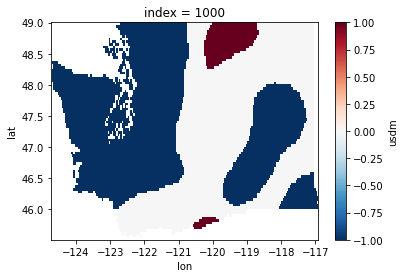

In [35]:
usdm_psdi_paired_ds['usdm'].sel(index=1000).plot()

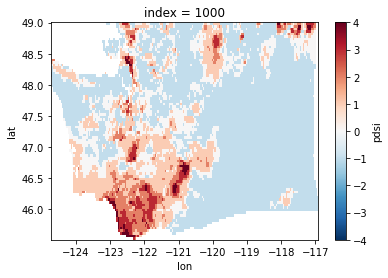

In [36]:
usdm_psdi_paired_ds['pdsi'].sel(index=1000).plot()

(array([7914110.,       0., 3016657.,       0., 1614565.,       0.,
        1012290.,       0.,  230379.,   63194.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

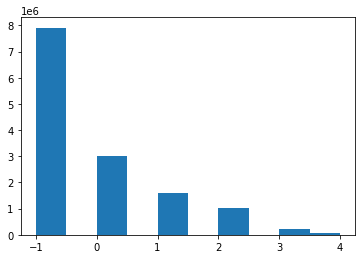

In [37]:
plt.hist(usdm_psdi_paired_ds['usdm'].values.ravel())

(array([9195067.,       0., 1714527.,       0., 1703830.,       0.,
         852093.,       0.,  499187.,  374816.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

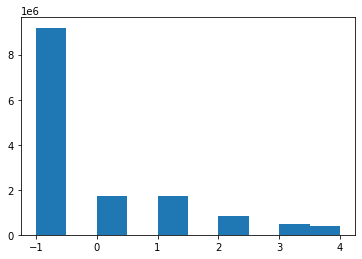

In [38]:
plt.hist(usdm_psdi_paired_ds['pdsi'].values.ravel())

That looks good

One thing that would be good is modifying this for data that has multiple intervals, so it's less toll on the machine

In [39]:
usdm_pairings['spi']['spi'].name

'spi'

In [40]:
def create_paired_ds(da_a:list, da_b:list, dates_a:pd.DataFrame, dates_b:pd.DataFrame, rescale=False):
    lat_a = da_a[0].lat
    lat_b = da_b[0].lat
    lon_a = da_a[0].lon
    lon_b = da_b[0].lon

    if len(lat_a) != len(lat_b) or len(lon_a) != len(lon_b):
        if rescale:
            if len(lat_a) > len(lat_b) or len(lon_a) > len(lon_b):
                da_a_rescaled = [da.rio.reproject_match(da_b[0]).rename({'x':'lon', 'y':'lat'}) for da in da_a]
                da_a = da_a_rescaled
            else:
                da_b_rescaled = [da.rio.reproject_match(da_a[0]).rename({'x':'lon', 'y':'lat'}) for da in da_b]
                da_b = da_b_rescaled
        else:
            raise Exception('Coordinates are different scales. Either fix or set rescale to True to enable auto upscaling.')
    elif lat_a != lat_b or lon_a != lon_b:
        raise Exception('Coordinates do not match despite same size.')
        

    index = dates_a.index.values
    if np.any(index != dates_b.index.values):
        raise Exception('Dates are not paired to the same index.')


    paired_ds = xr.Dataset(
        coords=dict(
            index=(['index'], index),
            lat=(['lat'], da_a[0].lat.values),
            lon=(['lon'], da_a[0].lon.values),
        )
    )
    paired_ds['index'] = index
    
    for da in da_a:
        paired_ds[da.name] = xr.DataArray(
            da.values,
            dims = ['index', 'lat', 'lon'],
            coords=dict(
                index=index,
                lat=paired_ds.lat.values,
                lon=paired_ds.lon.values,
            )
    )
    
    
    paired_ds[f'{dates_a.name.upper()} Date'] = xr.DataArray(
        dates_a.values,
        dims=['index'],
        coords=dict(index=index)
    )

    for da in da_b:
        paired_ds[da.name] = xr.DataArray(
            da.values,
            dims=['index', 'lat', 'lon'],
            coords=dict(
                index=index,
                lat=paired_ds.lat.values,
                lon=paired_ds.lon.values,
            )
        )
    paired_ds[f'{dates_b.name.upper()} Date'] = xr.DataArray(
        dates_b.values,
        dims=['index'],
        coords=dict(index=index)
    )

    return paired_ds

In [41]:
usdm_spi_paired = create_paired_ds(
    [usdm['USDM'].sel(date=usdm_pairings['spi']['usdm'].values).rio.write_crs('EPSG:4326', inplace=True)],
    [spi[f'spi_{interval}'].sel(day=usdm_pairings['spi']['spi'].values).rio.write_crs('EPSG:4326', inplace=True) for interval in intervals],
    usdm_pairings['spi']['usdm'],
    usdm_pairings['spi']['spi'],
    rescale=True
)
usdm_spi_paired

<xarray.Dataset>
Dimensions:    (index: 1148, lat: 84, lon: 188)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
  * lat        (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon        (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
Data variables:
    USDM       (index, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    USDM Date  (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_14d    (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    spi_30d    (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    spi_90d    (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    spi_180d   (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    spi_270d   (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    spi_1y     (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    spi_2y     (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    spi_5y     (index, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SPI Date   (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26

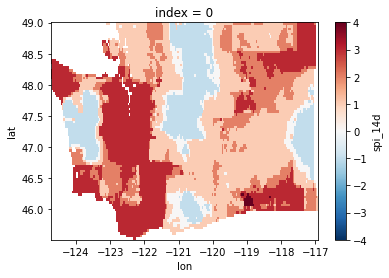

In [42]:
usdm_spi_paired['spi_14d'].sel(index=0).plot()

Woot

In [43]:
len(intervals)*3 + 2 + 3

29

scrap:

In [44]:
usdm_usdm_dates = pair_dates(usdm_dates, usdm_dates, 'usdm', 'usdm', realign=True, method='nearest')
usdm_usdm_dates

,usdm,usdm
0,2000-01-04,2000-01-04
1,2000-01-11,2000-01-11
2,2000-01-18,2000-01-18
3,2000-01-25,2000-01-25
4,2000-02-01,2000-02-01
...,...,...
1158,2022-03-15,2022-03-15
1159,2022-03-22,2022-03-22
1160,2022-03-29,2022-03-29
1161,2022-04-05,2022-04-05


In [45]:
np.any(usdm_usdm_dates.values[:, 0] != usdm_usdm_dates.values[:, 1])

False

In [46]:
usdm_usdm_dates.values

array([['2000-01-04T00:00:00.000000000', '2000-01-04T00:00:00.000000000'],
       ['2000-01-11T00:00:00.000000000', '2000-01-11T00:00:00.000000000'],
       ['2000-01-18T00:00:00.000000000', '2000-01-18T00:00:00.000000000'],
       ...,
       ['2022-03-29T00:00:00.000000000', '2022-03-29T00:00:00.000000000'],
       ['2022-04-05T00:00:00.000000000', '2022-04-05T00:00:00.000000000'],
       ['2022-04-12T00:00:00.000000000', '2022-04-12T00:00:00.000000000']],
      dtype='datetime64[ns]')

In [47]:
'usdm' is 'usdm'

True

In [48]:
usdm_self_dates = pd.to_datetime(list(set(usdm_usdm_dates.values.ravel())))

In [49]:
usdm_usdm_dates.index

RangeIndex(start=0, stop=1163, step=1)

In [50]:
pd.DataFrame(data=usdm_self_dates, columns=['usdm'])

,usdm
0,2000-01-04
1,2000-01-11
2,2000-01-25
3,2000-01-18
4,2000-02-01
...,...
1158,2018-12-11
1159,2012-05-08
1160,2013-10-08
1161,2011-03-08


## Pixel Stats

Here I plan to take a lot of the computations developed in `analysis/usdm_spi_pixel_compare.ipynb` and apply them to the nexus

### Lagged R Correlation

Actually I'm going to put this in a script to compute cause I'm p sure it's going to take a bit and I want it to be on tmux

Okay, so that's gong, and looks like is maybe going to take a bit to get everything done. But let's look at what we have so far

In [51]:
r_path = f'{dm_path}/ndrought_products/paired_r'

In [52]:
dm_vars_expanded = {
    'usdm':['USDM'],
    'spi':[f'spi_{interval}' for interval in intervals],
    'spei':[f'spei_{interval}' for interval in intervals],
    'eddi':[f'eddi_{interval}' for interval in intervals],
    'pdsi':['pdsi'],
    'grace':grace_vars
}

In [53]:
usdm_paired_r = dict()

for var in dm_vars:
    usdm_paired_r[var] = xr.open_dataset(f'{r_path}/usdm_{var}_r.nc')

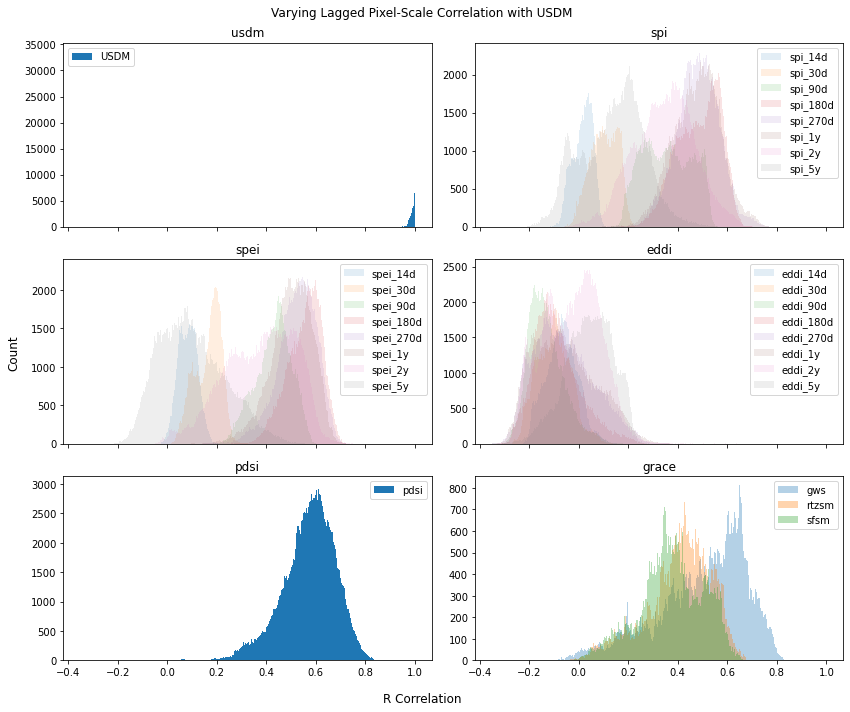

In [54]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = usdm_paired_r[var][f'USDM_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle('Varying Lagged Pixel-Scale Correlation with USDM')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

That's kind of interesting. 

So USDM having really high correlation with itself makes a lot of sense and is a good check.

The mid tiem window (180 or 270d) for SPI and SPEI seem to have the higher correlations ... while EDDI is really low. PDSI is pretty high too. And the groundwater storage (GWS) for grace is also on the higher side. 

It's good to keep in mind that these are all in agreement with drought categorized by USDM.



Now I'm really curious to see what the other things yeild.

Where is correlation the highest? What lag?

In [55]:
test_r = usdm_paired_r['pdsi']['USDM_pdsi_r'].copy()

In [56]:
test_r.values.shape

(84, 188, 41)

(array([   6.,    9.,    8.,   77.,  434., 1146., 2771., 4213., 2852.,
         539.]),
 array([-0.1036761 , -0.00802523,  0.08762563,  0.1832765 ,  0.27892736,
         0.37457823,  0.47022909,  0.56587996,  0.66153082,  0.75718169,
         0.85283255]),
 <BarContainer object of 10 artists>)

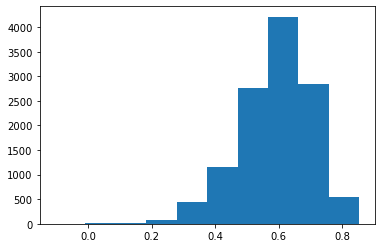

In [57]:
plt.hist(np.max(test_r.values, axis=2).ravel())

In [58]:
max_lag = np.argmax(test_r.values, axis=2)-20.0
max_lag[np.isnan(test_r[:, :, 0].values)] = np.nan
max_lag

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

(array([  19.,  369.,  200.,  878.,  364., 9821.,  173.,  205.,   14.,
          12.]),
 array([-20., -16., -12.,  -8.,  -4.,   0.,   4.,   8.,  12.,  16.,  20.]),
 <BarContainer object of 10 artists>)

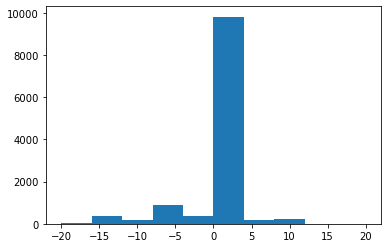

In [59]:
plt.hist(max_lag.ravel())

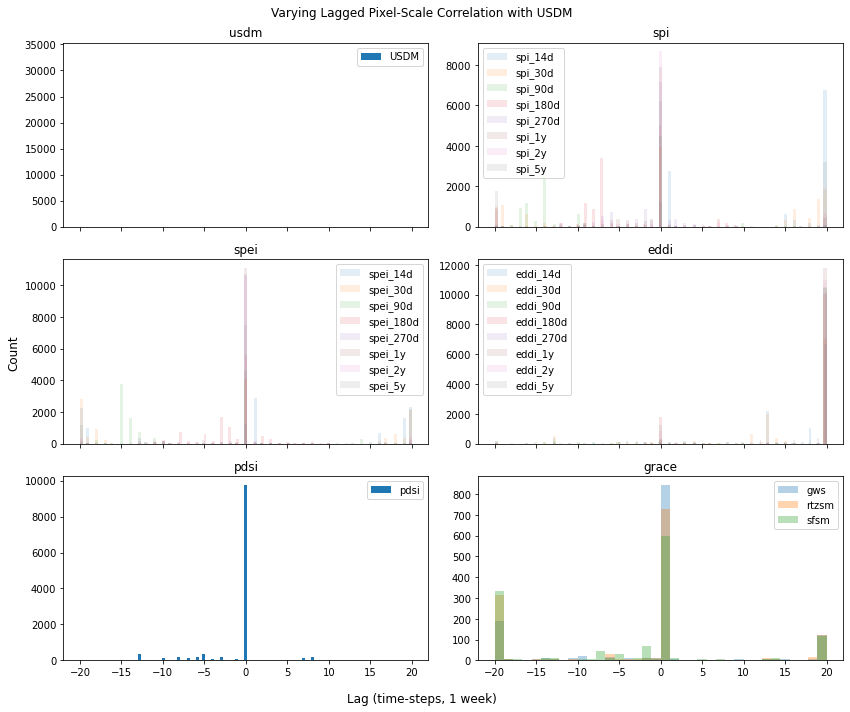

In [60]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = usdm_paired_r[var][f'USDM_{exp_var}_r'].values
        max_lag = np.argmax(data, axis=2) - 20.0
        max_lag[np.isnan(data[:, :, 0])] = np.nan

        data_points = max_lag[np.isnan(max_lag) == False]

        ax.hist(max_lag.ravel(), alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle('Varying Lagged Pixel-Scale Correlation with USDM')
fig.supylabel('Count')
fig.supxlabel('Lag (time-steps, 1 week)')
plt.tight_layout()

So the ones that stack up at the ends I'm attributing more so to noise than anything else really. Seems like most of the correlation in ones that line up well is with nearly no lag, interesting. I wonder if this is because USDM is a retrospective measure ... and I paired it with whatever data was last available ... so it makes sense that that's what's reflective.

SPI series finished!

Looks like runs are taking anywhere from 40 sec to 80 sec ... er I think double that cause that's each the computing & reshaping and storing processes

In [61]:
spi_paired_r = dict()

for var in dm_vars:
    spi_paired_r[var] = xr.open_dataset(f'{r_path}/spi_{var}_r.nc')

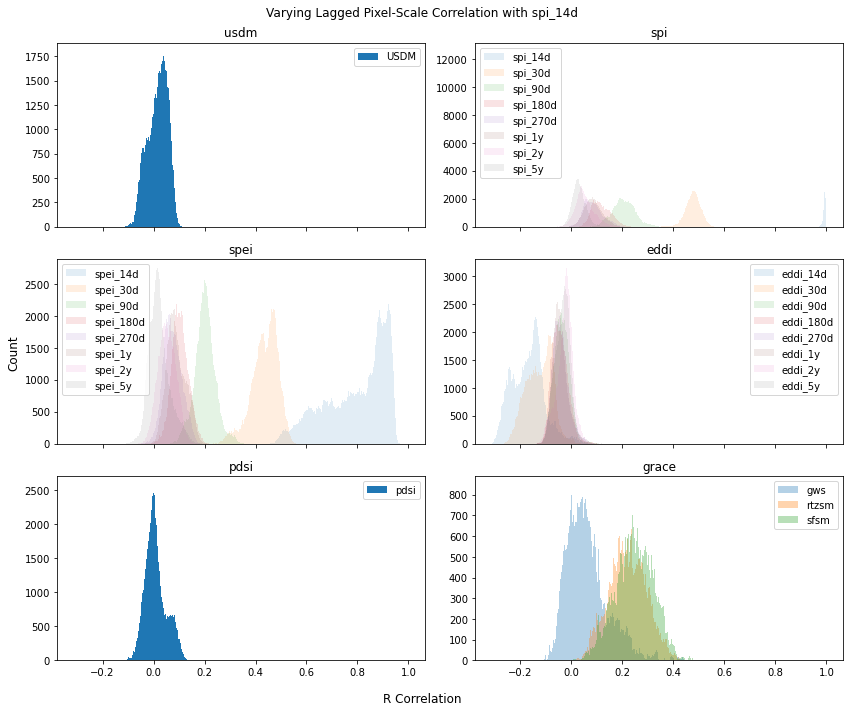

In [62]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_14d'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

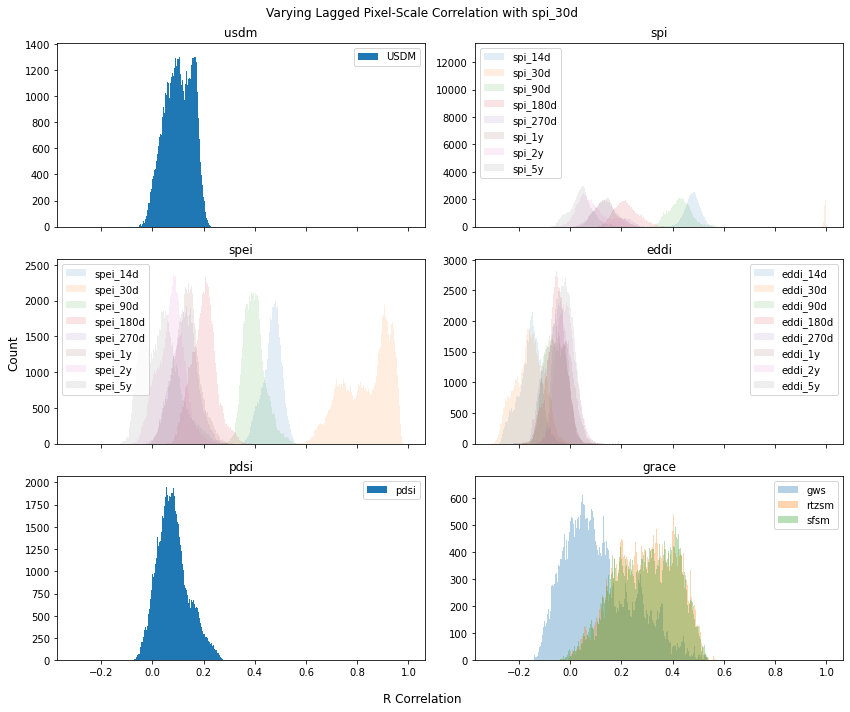

In [63]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_30d'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

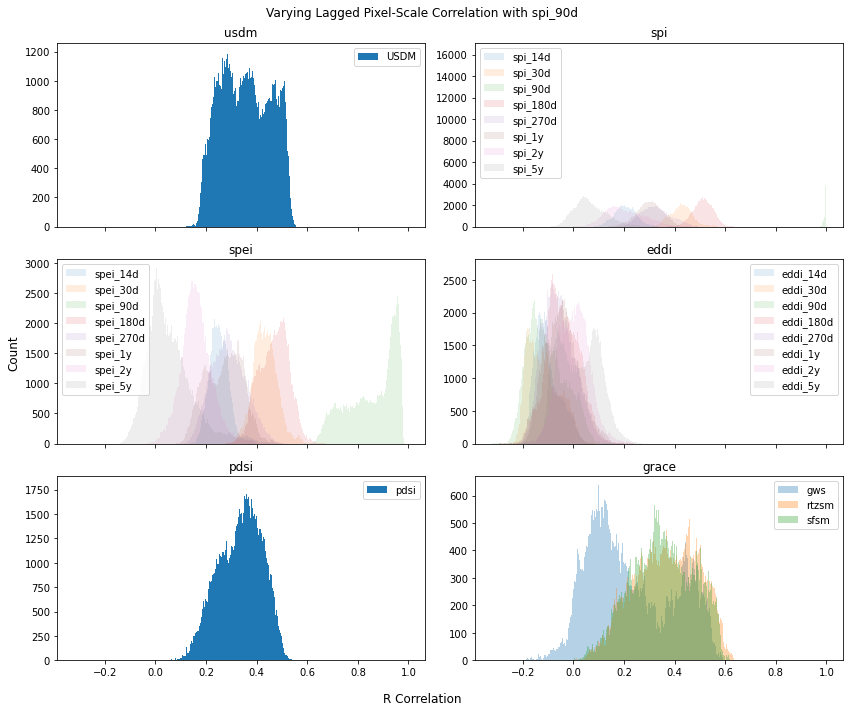

In [64]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_90d'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

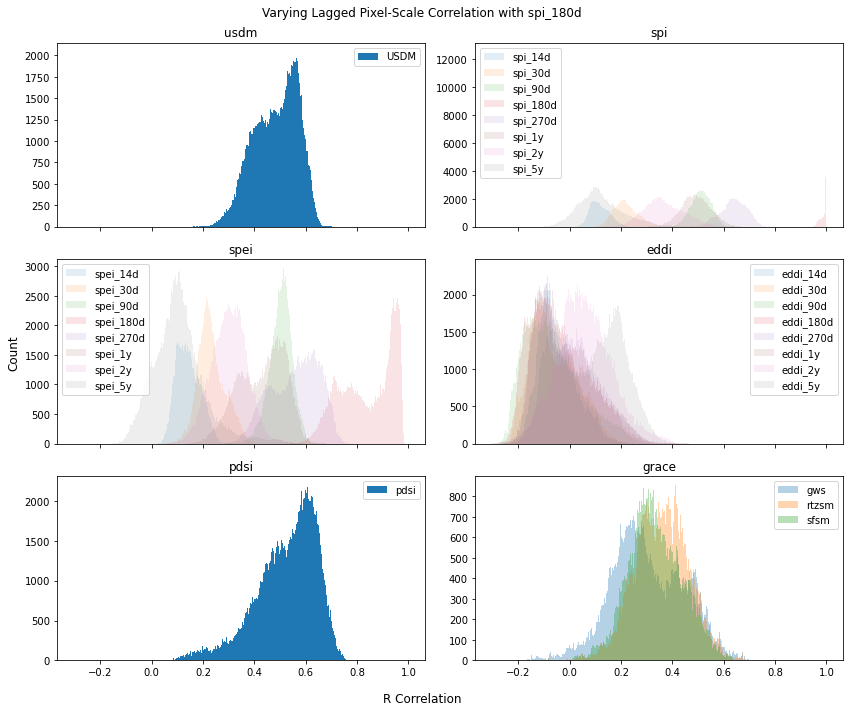

In [65]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_180d'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

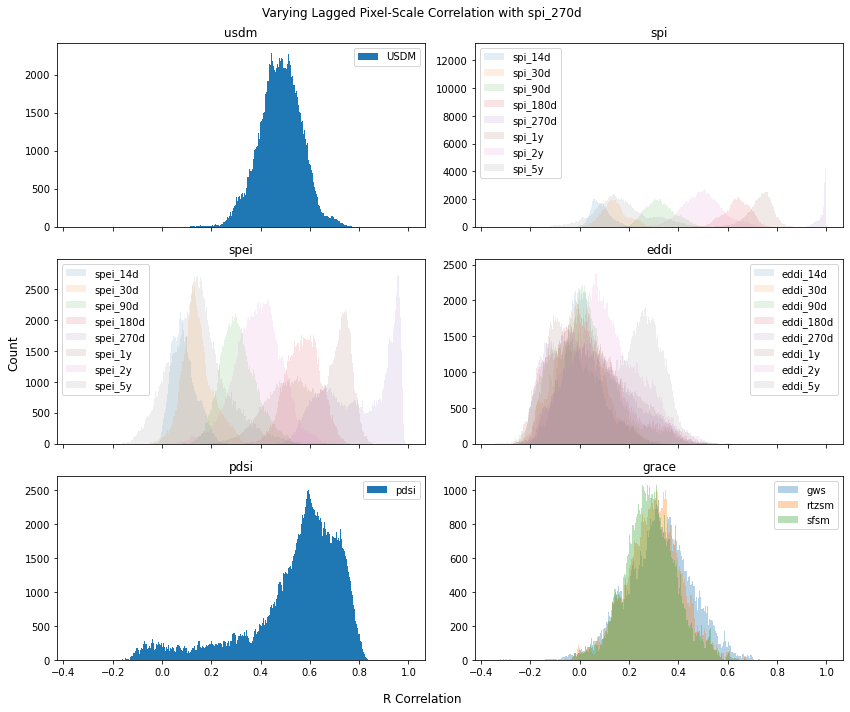

In [66]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_270d'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

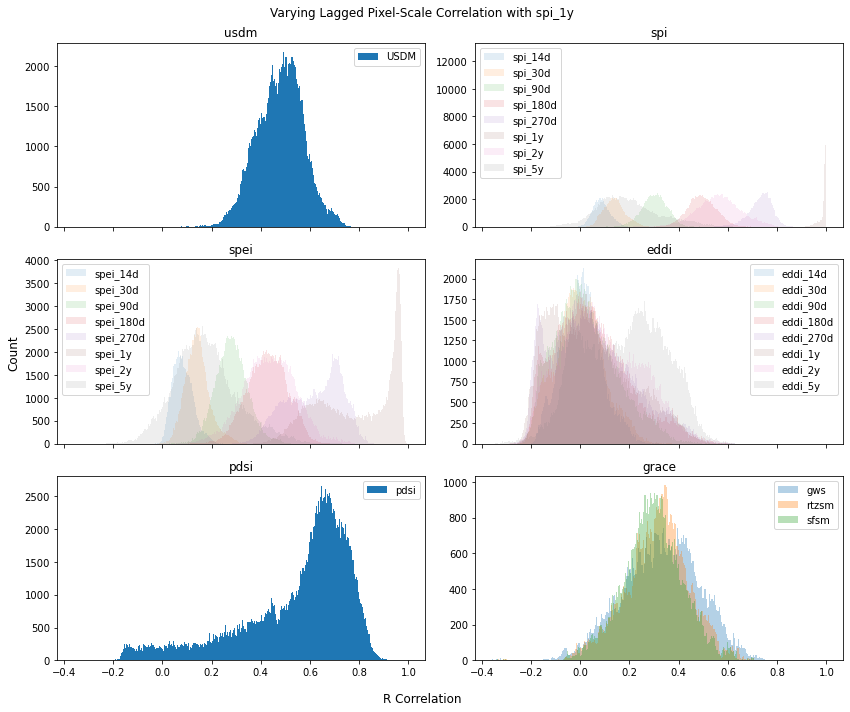

In [67]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_1y'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

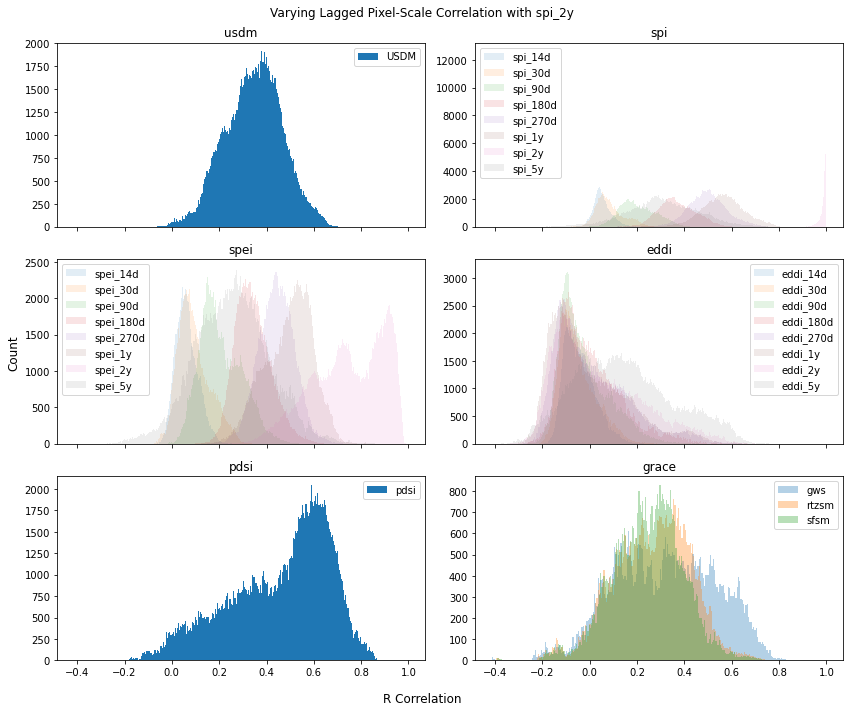

In [68]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_2y'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

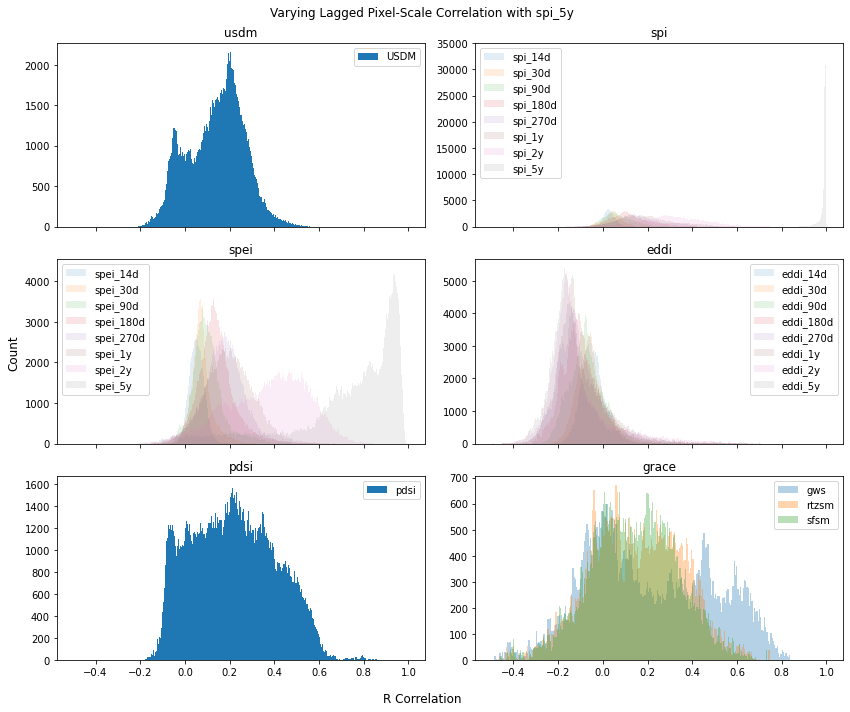

In [69]:
fig, axs = plt.subplots(3,2, figsize=(12,10), sharex=True)

spi_var = 'spi_5y'

for ax, var in zip(axs.ravel(), dm_vars):
    expanded_vars = dm_vars_expanded[var]
    i_alpha = 1/len(expanded_vars)

    for exp_var in expanded_vars:
        data = spi_paired_r[var][f'{spi_var}_{exp_var}_r'].values.ravel()
        data_points = data[np.isnan(data) == False]
        ax.hist(data, alpha=i_alpha, label=exp_var, bins=int(np.sqrt(len(data_points))))
        ax.set_title(var)
        ax.legend()

fig.suptitle(f'Varying Lagged Pixel-Scale Correlation with {spi_var}')
fig.supxlabel('R Correlation')
fig.supylabel('Count')
plt.tight_layout()

I'm going to move these plots to a new notebook to help keep things a bit clean